In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder
from sklearn.metrics import *

import keras

#from keras.utils.np_utils import to_categorical
import os
import numpy as np
import scipy as sp

import urllib.request
import shutil
import tarfile

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import matplotlib.pyplot as plt
import time
import logging
from typing import List, Tuple, Generator, Iterator
import random

np.random.seed(0)
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.neighbors import LocalOutlierFactor
!pip install pyod
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.inne import INNE

2024-08-14 21:17:12.064407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 21:17:12.071940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 21:17:12.081978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 21:17:12.081995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 21:17:12.088722: I tensorflow/core/platform/cpu_feature_gua

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# **Preprocessing Data**

In [3]:
df = pd.read_csv('Dataset/BoT-IoT-2018_37k_dataset_normal_and_scan.csv')
df

,stime,flgs,sport,dport,pkts,bytes,state,ltime,seq,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,category
0,1528086204,0,41307,8883,4,1765,0,1528086206,138245,1.840775,1.840775,0.000000,1.840775,1.840775,1.840775,2,2,1633,132,1.629748,0.543249,0.543249,0_normal
1,1528086238,4,0,0,6570,6402577,0,1528086281,1963,42.851730,4.750916,0.683063,42.758240,2.818930,4.996529,3284,3286,3096045,3306532,153.296021,76.613007,76.659683,0_normal
2,1528086238,0,0,0,6570,6392194,0,1528086281,2156,42.850605,4.750905,0.683059,42.758144,2.818939,4.997464,3286,3284,3123006,3269188,153.300049,76.661697,76.615021,0_normal
3,1528086238,0,0,0,3286,3154001,3,1528086281,2157,42.850590,4.750456,0.683887,42.754105,2.816143,4.996534,3286,0,3154001,0,76.661720,76.661720,0.000000,0_normal
4,1528086238,0,0,0,3284,3073335,0,1528086281,2350,42.850128,4.750597,0.683655,42.755367,2.816950,4.997455,3284,0,3073335,0,76.615875,76.615875,0.000000,0_normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37735,1528086662,0,0,0,3146,3020104,3,1528086704,1939,42.018288,4.364014,1.311239,39.276127,0.925813,4.995116,3146,0,3020104,0,74.848358,74.848358,0.000000,0_normal
37736,1528086662,0,0,0,3146,2942735,0,1528086704,2132,42.018154,4.363707,1.315489,39.273361,0.913057,4.999728,3146,0,2942735,0,74.848602,74.848602,0.000000,0_normal
37737,1528086662,0,0,0,1889,1341493,0,1528086704,2133,42.007420,4.354401,1.314757,39.189610,0.902321,4.999726,1889,0,1341493,0,44.944443,44.944443,0.000000,0_normal
37738,1528086662,0,0,0,1691,101460,3,1528086704,4438,42.005527,4.352437,1.316963,39.171936,0.897394,4.999726,1691,0,101460,0,40.232800,40.232800,0.000000,0_normal


### Prepare data

In [4]:
def remove_outliers_lof(X_data, y_data, contamination=0.05, random_seed=None):
    """
    Remove outliers from a dataset using Local Outlier Factor (LOF).

    Parameters:
    - X_data: numpy array, feature matrix
    - y_data: numpy array, label array
    - contamination: float, the proportion of outliers in the dataset
    - random_seed: int or None, seed for reproducibility

    Returns:
    - X_no_outliers: numpy array, feature matrix without outliers
    - y_no_outliers: numpy array, label array without outliers
    """

    unique_classes = np.unique(y_data)

    X_no_outliers = np.empty((0, X_data.shape[1]), dtype=X_data.dtype)
    y_no_outliers = np.empty(0, dtype=y_data.dtype)

    for label in unique_classes:
        # Select samples belonging to the current class
        # print(label)
        class_mask = (y_data == label)
        X_class = X_data[class_mask]
        if label == 0:
            X_no_outliers = np.vstack((X_no_outliers, X_class))
            y_no_outliers = np.concatenate((y_no_outliers, y_data[class_mask]))
        else:
            # Apply LOF to detect outliers
            lof = LocalOutlierFactor(contamination=contamination)
            outliers_mask = lof.fit_predict(X_class) == -1

            # Remove outliers from the current class
            X_no_outliers = np.vstack((X_no_outliers, X_class[~outliers_mask]))
            y_no_outliers = np.concatenate((y_no_outliers, y_data[class_mask][~outliers_mask]))

    return X_no_outliers, y_no_outliers

def prepare_data(data, target, cls_drop):
    classes = np.unique(target)
    if __MODE == "Novelty_multi":
        mask = ~np.isin(classes, cls_drop)
        known = classes[mask]
    elif __MODE == "1_Cls":
        known = "0_normal"
    else:
        known = classes


    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3, stratify = target, random_state=__SEED)


    # Loại bỏ các class không biết trong tập train
    mask = np.array([y in known for y in target_train])

    X_train = data_train[mask]
    y_train = target_train[mask]

    idx = y_train.argsort()
    X_train = X_train[idx]
    y_train = y_train[idx]

    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    X_test = data_test
    y_labels = target_test

    if __MODE == "Novelty_multi":
        # Test labels are 1 if novel, otherwise 0.
        # y_test_bina = np.array([1 if cl not in known else 0 for cl in y_labels])
        y_test = np.array([-1 if cl not in known else encoder.transform([cl])[0] for cl in y_labels])
        # y_test = np.array([cl+"-1" if cl not in known else cl for cl in y_labels])


    if __MODE == "Supervise":
        # y_test_bina = np.array([1 if cl != 0 else 0 for cl in y_labels])

        y_test = encoder.transform(y_labels)

    if __MODE == "1_Cls":
        y_test = np.array([1 if cl not in known else encoder.transform([cl])[0] for cl in y_labels])

    # encoder = LabelEncoder()
    # y_test = encoder.fit_transform(y_test)
    # y_train = encoder.transform(y_train)
    classes = np.unique(y_train)


    return X_train, y_train, X_test, y_test, classes, encoder

In [5]:
def Get_Scaler(name):
  # (StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
  if name == "StandardScaler":
    return StandardScaler()
  if name == "MinMaxScaler":
    return MinMaxScaler()
  if name == "RobustScaler":
    return RobustScaler()
  if name == "Normalizer":
    return Normalizer()
  if name == "QuantileTransformer":
      return QuantileTransformer(output_distribution = "normal", random_state=__SEED)
  return None

def preprocess_data(drop_cls, data):
    datasets = data.to_numpy()
    labels = datasets[:,-1]
    dataset = datasets[:,:-1]


    ## ========================== Running Main Model ================================================

    X_train, y_train, X_test, y_test, classes_tmp, encoder = prepare_data(dataset, labels, drop_cls)

    # print(f"X_train shape: {X_train.shape}")
    # print(f"y_train counts: {np.unique(y_train, return_counts=True)}")

    # X_train, y_train = reduce_trainning_data(X_train, y_train)


    ## ========================== Scaler data ================================================
    scaler = Get_Scaler(name=__SCALER)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Remove outliers
    X_train, y_train= remove_outliers_lof(X_train, y_train)

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train counts: {np.unique(y_train, return_counts=True)}")

    print(f"X_test shape: {X_test.shape}")
    print(f"y_test counts: {np.unique(y_test, return_counts=True)}")

    return X_train, y_train, X_test, y_test, classes_tmp, encoder

# INNR

### INNR function

In [6]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import classification_report

def K(X,Y=None,metric='poly',coef0=1,gamma=None,degree=3):
    if metric == 'poly':
        k = pairwise_kernels(X,Y=Y,metric=metric,coef0=coef0,gamma=gamma,degree=degree)
    elif metric == 'linear':
        k = pairwise_kernels(X,Y=Y,metric=metric)
    elif metric == 'sigmoid':
        k = pairwise_kernels(X,Y=Y,metric=metric,coef0=coef0,gamma=gamma)
    elif metric == 'rbf':
        k = pairwise_kernels(X,Y=Y,metric=metric,gamma=gamma)
    return k

def kernel_distance_matrix(matrix1 = None, matrix2 = None, kernel=None, gamma=None):
    """
    Calculate the distance between two matrices using the kernel trick.
    Parameters:
    - matrix1: The first input matrix (NumPy array).
    - matrix2: The second input matrix (NumPy array).
    - gamma: The gamma parameter for the RBF kernel.
    Returns:
    - distance_matrix: The distance matrix between the two input matrices.
    """

    if matrix1.shape[1] != matrix2.shape[1]:
        raise ValueError("The number of features in the input matrices must be the same.")
    Kaa = []
    for i in range(len(matrix1)):
        Kaa.append(K(matrix1[i,:].reshape(1,-1),metric=kernel))
    Kaa = np.asarray(Kaa).ravel().reshape(len(Kaa),1)
    Kab = K(matrix1,matrix2,metric=kernel)
    Kbb = []
    for i in range(len(matrix2)):
        Kbb.append(K(matrix2[i,:].reshape(1,-1),metric=kernel))
    Kbb = np.asarray(Kbb).ravel()
    d = Kaa-2*Kab+Kbb #shape: (matrix1,matrix2)
    return d

def calculate_accuracy_for_label(y_true, y_predict, label):
    """
    Calculate accuracy for a specific label.

    Parameters:
    - y_true: The true labels (1D NumPy array).
    - y_predict: The predicted labels (1D NumPy array).
    - label: The specific label for which to calculate accuracy.

    Returns:
    - accuracy: The accuracy for the specified label.
    """
    # Create a boolean mask for the specified label
    mask = (y_true == label)

    # Extract true labels and predicted labels for the specified label
    true_labels_for_label = y_true[mask]
    predicted_labels_for_label = y_predict[mask]


    # Calculate accuracy for the specified label
    accuracy = np.mean(true_labels_for_label == predicted_labels_for_label)
    # print(accuracy)
    return accuracy


class kINN:
    def __init__(self, R=1, kernel="linear", mode = "Supervise"):
        self.R = R
        self.kernel = kernel
        self.distance_matrix = None
        self.cluster_labels = None
        self.cluster_map = None
        self.N = None
        # self.n_clusters = n_clusters
        self.X = None
        self.M = None
        self.is_fit = False
        self.DNN_test = None
        self.distance_matrix_test = None
        self.mode = mode



    def _Bruteforce_threshold(self, y_test, y_pred, scores):
        # d = Decimal(np.min(scores))
        # min_th = max(1e-8,pow(10, d.as_tuple().exponent))
        # d = Decimal(np.max(scores))
        # max_th = min(1e-2,pow(10, d.as_tuple().exponent))

        # print("======================= DEBUG =======================")
        # print(min_th, max_th)
        # print("======================= DEBUG =======================")
        min_th = 1e-7
        max_th = 1e-1
        # __step = int(max_th / min_th)
        __step = 10000
        mcc = matthews_corrcoef(y_test, y_pred)
        mcc = 0
        ndr = 0
        y_pred_adv = y_pred


        __rag = np.unique(y_test)
        thr = -np.ones(len(__rag))

        for id in __rag[1:]:
            # print("DEBUG:", id)
            for x in np.linspace(min_th, max_th, num=__step):
                y_pred_adv_tmp = np.array([-1 if (y_p == id) and (sc > x) else y_p for y_p, sc in zip( y_pred,scores)])
                mcc_tmp = matthews_corrcoef(y_test, y_pred_adv_tmp)
                ndr_tmp = calculate_accuracy_for_label(y_test, y_pred_adv_tmp, -1)
                if np.mean([mcc_tmp*2,ndr_tmp]) > np.mean([mcc*2,ndr]):
                    y_pred_adv = y_pred_adv_tmp
                    mcc = mcc_tmp
                    ndr = ndr_tmp
                    thr[id] = x
            y_pred = y_pred_adv
        print("DEBUG - update mcc:", mcc, ndr, thr)
        return y_pred_adv, mcc, thr


    def _Bruteforce_threshold_1_cls(self, y_test, y_pred, scores):
          # d = Decimal(np.min(scores))
          # min_th = max(1e-8,pow(10, d.as_tuple().exponent))
          # d = Decimal(np.max(scores))
          # max_th = min(1e-2,pow(10, d.as_tuple().exponent))

          # print("======================= DEBUG =======================")
          # print(min_th, max_th)
          # print("======================= DEBUG =======================")
          min_th = 1e-7
          max_th = 1e-1
          # __step = int(max_th / min_th)
          __step = 10000
          mcc = matthews_corrcoef(y_test, y_pred)
          mcc = 0
          ndr = 0
          y_pred_adv = y_pred


          __rag = np.unique(y_test)
          thr = -np.ones(len(__rag))


          # for id in __rag[0]:
          id = 0
          for x in np.linspace(min_th, max_th, num=__step):
              y_pred_adv_tmp = np.array([1 if (y_p == id) and (sc > x) else y_p for y_p, sc in zip( y_pred,scores)])
              mcc_tmp = matthews_corrcoef(y_test, y_pred_adv_tmp)
              ndr_tmp = calculate_accuracy_for_label(y_test, y_pred_adv_tmp, 1)
              if np.mean([mcc_tmp*2,ndr_tmp]) > np.mean([mcc*2,ndr]):
                  y_pred_adv = y_pred_adv_tmp
                  mcc = mcc_tmp
                  ndr = ndr_tmp
                  thr[id] = x
          y_pred = y_pred_adv


          print("DEBUG - update mcc:", mcc, ndr, thr)
          return y_pred_adv, mcc, thr



    def fit(self, X, y = None, single = False, type = "distance"):
        """
        Fit the kINN model to the input data.

        Parameters:
        - X: Input data, a 2D numpy array where each row represents a sample.
        - y: Input label, a array where each row represents a label for corresponding label
        - type: the strategy to calculate distance, support:
                                                            + "distance" - use only distance
                                                            + "density" - use LOF score as weight when calculate distance
        """
        self.X = X
        if (y is None) and (self.mode == "1_Cls"):
          # -np.ones(self.N, dtype=int)
          y = np.zeros(X.shape[0], dtype=int)
        self._fit_classify(X,y,type)
        self.is_fit = True
        if single == True:
            X_new = self.__map_to_single_point(X)

            return X_new, self.cluster_labels, self.cluster_map
        else:
            return self.cluster_labels, self.cluster_map


    def _calculate_lof(self, dis_mat, k_dis, d_nn, N_cnt):
        # calculate reachability distance

        re_dis_k = np.array([ [ max(dis_mat[i,k],k_dis[k]) for k in range(N_cnt) ] for i in range(N_cnt)])

        # calculate Local Reachability Density (LRD)

        lrd = np.array([1. / np.mean(re_dis_k[x, d_nn[x]]) for x in range(N_cnt)])

        # calculate LOF
        lof = np.array([np.mean(lrd[d_nn[x]]) / lrd[x] for x in range(N_cnt)])

        return lof

    def _fit_classify(self, X, y, type="distance"):
        N = X.shape[0]
    
        D_NN = np.empty((N,), dtype=object)
        INNR = np.empty((N,), dtype=object)
    
        classes, cls_cnt = np.unique(y, return_counts=True)
    
        for cls, N_cnt in zip(classes, cls_cnt):
            indicates = np.asarray(y == cls).nonzero()[0]
            X_cls = X[indicates]
            y_cls = y[indicates]
    
            dis_mat = kernel_distance_matrix(matrix1=X_cls, matrix2=X_cls, kernel=self.kernel)
    
            if type == "density":
                k_dis = -np.ones(N_cnt, dtype=float)
                d_nn = np.empty((N_cnt,), dtype=object)
                re_dis_k = -np.ones((N_cnt, N_cnt), dtype=float)
    
                for i in range(N_cnt):
                    dis_mat[i, i] = 0
                    tmp = dis_mat[i, :].argsort()
    
                    # Some case that 2 point are too close
                    dnn_tmp = [i]
                    cnt = 0
                    for x in tmp:
                        if abs(dis_mat[i, dnn_tmp[-1]] - dis_mat[i, x]) > 1e-9:
                            dnn_tmp.append(x)
                            cnt += 1
                            k_dis[i] = dis_mat[i, x]
                        else:
                            dnn_tmp.append(x)
    
                        if cnt >= self.R:
                            break
                    d_nn[i] = np.array(dnn_tmp[1:])
    
                lof = self._calculate_lof(dis_mat, k_dis, d_nn, N_cnt)
    
                # Update new matrix
                dis_mat = np.array([[dis_mat[i, k] * lof[k] for k in range(N_cnt)] for i in range(N_cnt)])
    
            # calculate D_N
            for i in range(N_cnt):
                dis_mat[i, i] = 0
                tmp = dis_mat[i, :].argsort()
    
                id = indicates[i]
                D_NN[id] = np.array(indicates[tmp])
    
                # Some case that 2 point are too close
                dnn_tmp = [i]
                cnt = 0
                for x in tmp:
                    if abs(dis_mat[i, dnn_tmp[-1]] - dis_mat[i, x]) > 1e-9:
                        dnn_tmp.append(x)
                        cnt += 1
                    else:
                        dnn_tmp.append(x)
    
                    if cnt >= self.R:
                        break
    
                D_NN[id] = np.array(indicates[dnn_tmp[1:]])
    
            self.D_NN = D_NN
    
            for i in tqdm(indicates, desc=f"Processing class {cls}"):
                NN = D_NN[i]
                tmp = []
                for p in NN:
                    p_near_neighbor = D_NN[p]
                    if i in p_near_neighbor:
                        tmp.append(p)
    
                pair = (i, tmp)
                INNR[i] = pair
    
        self.INNR = INNR
        self.N = N
        self.cluster_labels, self.no_cluser = self._label_clusters()
    
        cluster_map = np.full(self.no_cluser, -1)
    
        for x_tmp, y_tmp in zip(self.cluster_labels, y):
            if cluster_map[x_tmp] == -1:
                cluster_map[x_tmp] = y_tmp
            else:
                if cluster_map[x_tmp] != y_tmp:
                    print("Debug - Loi KNN")
    
        self.cluster_map = cluster_map


    # def _fit_cluster(self,X):
    #     N = X.shape[0]
    #     dis_mat = kernel_distance_matrix(matrix1 = X, matrix2 = X, kernel = self.kernel)
    #     D_NN = []
    #     for i in range(N):
    #         dis_mat[i,i] = 0
    #         tmp = dis_mat[i,].argsort()
    #         D_NN.append(tmp)

    #     D_NN = np.array(D_NN)
    #     self.D_NN = D_NN
    #     INNR = []

    #     for i in range(N):
    #         NN = D_NN[i, 1:self.R+1]

        #     tmp = []
        #     for p in NN:
        #         p_near_neighbor = D_NN[p, 1:self.R+1]
        #         if i in p_near_neighbor:
        #             tmp.append(p)

        #     pair = (i, tmp)
        #     INNR.append(pair)
        # self.INNR = INNR

        # self.N = N
        # self.cluster_labels, self.no_cluser = self._label_clusters()

    def _label_clusters(self):
        """
        Label clusters using deep find search (DFS) algorithm.

        Parameters:
        - X: Input data, a 2D numpy array where each row represents a sample.

        Returns:
        - labels: A numpy array containing cluster labels for each sample.

        """
        # print(self.INN)
        labels = -np.ones(self.N, dtype=int)
        current_label = 0

        # INNR = sorted(self.INNR,key=lambda x: len(x[1]), reverse=True)
        for x in self.INNR:
            id = x[0]
            if labels[id] == -1:
                queue = [id]
                labels[id] = current_label
                # _debug = 0
                for q in queue:
                    neighbors = self.INNR[q][1]
                    for neighbor in neighbors:
                        if labels[neighbor] == -1:
                            queue.append(neighbor)
                            labels[neighbor] = current_label
                current_label += 1
        return labels, current_label

    def _dfs_label_clusters(self, i, current_label, labels):
        """
        DFS algorithm to label clusters.

        Parameters:
        - X: Input data, a 2D numpy array where each row represents a sample.
        - i: Index of the current sample being explored.
        - current_label: Current cluster label.
        - labels: A numpy array containing cluster labels for each sample.

        """
        if labels[i] != -1:
            return

        labels[i] = current_label

        neighbors = self.INNR[i][1]
        for neighbor in neighbors:
            #
            self._dfs_label_clusters(neighbor, current_label, labels)

    def __map_to_single_point(self, X):

        a = self.cluster_labels
        x_new = []
        a_new = []
        for cl in np.unique(a):
            mask = np.isin(a, cl)
            known = X[mask]
            a_new.append(self.cluster_map[cl])
        # print(x_new)
        # print(a_new)
        self.cluster_labels = np.array(a_new)


        return np.array(x_new)

    def find_nearest_neighbors(self, X, x_i):
        """
        Find the R nearest neighbors of x_i using kernel trick.

        Parameters:
        - x_i: The input sample.

        Returns:
        - neighbors: A set of R nearest neighbors for x_i.

        """
        if self.distance_matrix is None:
            raise ValueError("Model not fitted. Call fit() first.")

        # Calculate kernel vector
        kernel_vector = self.distance_matrix[x_i].flatten()

        # Get indices of R nearest neighbors
        nearest_indices = np.argsort(kernel_vector)[1:self.R+1]

        return set(nearest_indices)


    def predict(self, X_test, y = None):
        """
        Predict the cluster labels for the input samples.

        Parameters:
        - X_test: Input data, a 2D numpy array where each row represents a sample.

        Returns:
        - predicted_labels: A numpy array containing predicted cluster labels for each sample.

        """
        if self.is_fit == False:
            raise ValueError("Model not fitted. Call fit() first.")


        N_test = X_test.shape[0]
        self.M = N_test
        dis_mat_X_test = kernel_distance_matrix(matrix1 = X_test, matrix2 = self.X, kernel = self.kernel)
        self.distance_matrix_test = dis_mat_X_test
        D_NN_test = []
        # print("Khoảng cách X_test -> X_train:\n ",dis_mat_X_test,"\n")
        for i in range(N_test):
            # dis_mat_X_test[i,i] = 0
            tmp = dis_mat_X_test[i,].argsort()
            D_NN_test.append(tmp)

        D_NN_test = np.array(D_NN_test)
        # print(D_NN_test.shape)
        self.D_NN_test = D_NN_test
        INNR_X_test = []
        # Tìm INNR_X_test
        for i in range(N_test):
            NN = D_NN_test[i, 1:self.R+1]
            # print(NN)
            tmp = []
            for p in NN:
                p_near_neighbor = D_NN_test.T[p, 1:self.R+1]
                # print("neighbor: ",p_near_neighbor)
                if i in p_near_neighbor:
                    # print(p_near_neighbor)
                    tmp.append(p)
            pair = (i, tmp)
            # print(pair)
            INNR_X_test.append(pair)
        self.INNR_test = INNR_X_test


        if self.mode == "Supervise":
            labels = self._predict_multi()
            return labels
        elif self.mode == "Novelty_multi":
            labels,mcc, threshold  = self._predict_novelty(y)
            return labels , mcc, threshold
        else:
            labels,mcc, threshold = self._predict_1Class(y)
            return labels, mcc, threshold



    def _predict_multi(self):
        labels = -np.ones(self.M, dtype=int)
        # c = 0
        for pair in self.INNR_test:
                idx = pair[0]
                if pair[1] != []:  # Kiểm tra xem danh sách neighbor có rỗng không
                    neighbors = pair[1]
                    # print(id, "neigibor = ",neighbors)
                    labels[idx] = self.cluster_map[self.cluster_labels[neighbors[0]]]
                    # c+= 1
                    # print(self.cluster_labels[neighbors[0]])
                else:
                    labels[idx] = self.cluster_map[self.cluster_labels[self.D_NN_test[idx][0]]]
        # print("Count: ",c)
        return labels


    def _predict_novelty(self, y):
        scores_mat = self.distance_matrix_test
        y_pred = [self.cluster_labels[x] for x in np.argmin(scores_mat, axis=1)]

        for i in range(self.M):
            y_pred[i] = self.cluster_map[y_pred[i]]

        scores = np.amin(scores_mat, axis=1)
        y_pred_adv, mcc, threshold = self._Bruteforce_threshold(y, y_pred, scores)


        print(f"MCC: {mcc}", f"threshold: {threshold}")

        return y_pred_adv, mcc, threshold


    def _predict_1Class(self,y):

        scores_mat = self.distance_matrix_test
        # print(scores_mat)
        # y_pred = [self.cluster_labels[x] for x in np.argmin(scores_mat, axis=1)]

        # for i in range(self.M):
        #     y_pred[i] = self.cluster_map[y_pred[i]]
        y_pred = np.zeros(self.M, dtype = int)
        scores = np.amin(scores_mat, axis=1)
        y_pred_adv, mcc, threshold = self._Bruteforce_threshold_1_cls(y, y_pred, scores)
        # print("DEBUG- y_pred: ", y_pred)

        print(f"MCC: {mcc}", f"threshold: {threshold}")

        return y_pred_adv, mcc, threshold

### INNR_evaluation function

In [7]:
# basic random seed
from sklearn.manifold import TSNE

__CUSTOM_COLS=['MCC', 'ACC','TPR', 'FPR', 'F1', 'TPR macro','PPV macro','F1 macro',"AUC","Training time","Testing time"]
__DEFAULT_RANDOM_SEED = 42

def seedEverything(seed=__DEFAULT_RANDOM_SEED):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

  # # tensorflow random seed
  # import tensorflow as tf
  # tf.random.set_seed(seed)

  # # torch random seed
  # import torch
  # torch.manual_seed(seed)
  # torch.cuda.manual_seed(seed)
  # torch.backends.cudnn.deterministic = True
  # torch.backends.cudnn.benchmark = False



def cfs_matrix(y_label, y_pred, labels):

    cfs_mt = np.full((len(labels), len(labels)), 0)

    for x,y in zip(y_label, y_pred):
        cfs_mt[x,y] += 1

    return cfs_mt

def calc_index(testdf, Label_name, export_fig):

  #     P
  #     0   1
  # T 0 TN FP
  #   1 FN TP

    # print("Debug")
    # print(np.unique(testdf.label))
    # print(np.unique(testdf.y_pred))
    cnf_matrix = confusion_matrix(testdf.label, testdf.y_pred, labels = np.unique(testdf.label))
  #   # plot_confusion_matrix("Model_cfs",cnf_matrix, target_names=Label_name,figsize = (20, 10), export_fig=export_fig)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)


  #   if len(Label_name) == 2:
  #       TN = cnf_matrix[0,0]
  #       FP = cnf_matrix[0,1]
  #       FN = cnf_matrix[1,0]
  #       TP = cnf_matrix[1,1]

  # # Sensitivity, hit rate, recall, or true positive rate
  #   TPR = TP/(TP+FN) *100.
  #   # Specificity or true negative rate
  #   TNR = TN/(TN+FP) *100.
  #   # Precision or positive predictive value
  #   PPV = TP/(TP+FP) *100.
  #   # Negative predictive value
  #   NPV = TN/(TN+FN) *100.
    # Fall out or false positive rate
    FPR = FP/(FP+TN) *100.
  #   # False negative rate
  #   FNR = FN/(TP+FN) *100.
  #   # False discovery rate
  #   FDR = FP/(TP+FP) *100.
  #   # F1 Score
  #   F1 = 2 * (PPV * TPR) / (PPV + TPR)

  #   # Matthew’s correlation coefficient
  #   MCC = ((TP * TN) - (FP * FN)) / (( (TP+FP) * (TP+FN) * (TN+FP) * (TN+FN) ) ** 0.5)

  #   # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN) *100.

    auc_func = -1
    # if len(Label_name) == 3:
    #     false_positive_rate, true_positive_rate, thresholds = roc_curve(testdf.label,  testdf.y_pred)
    #     auc_func = auc(false_positive_rate, true_positive_rate)

    tpr_func = recall_score(testdf.label,testdf.y_pred,average='macro', zero_division = 0) *100.
    ppv_func = precision_score(testdf.label,testdf.y_pred,average='macro', zero_division = 0) *100.
    f1_func = f1_score(testdf.label,testdf.y_pred,average='macro', zero_division = 0) *100.
    mcc_func = matthews_corrcoef(testdf.label,testdf.y_pred)
    # if len(Label_name) == 2:
    #     print("------------------------")
    #     logger.info("ACC: {:.4f}".format(ACC))
    #     logger.info("MCC: {:.4f}".format(MCC))
    #     logger.info("TPR: {:.4f}".format(TPR))
    #     logger.info("PPV: {:.4f}".format(PPV))
    #     logger.info("FPR: {:.4f}".format(FPR))
    #     logger.info("F1 : {:.4f}".format(F1))
    # else:
    ACC = sum(TP+TN)/(sum(TP+FP+FN+TN)) *100.
    #     TPR = sum(TP)/sum((TP+FN)) *100.
    #     PPV = sum(TP)/sum((TP+FP)) *100.
    FPR = sum(FP)/sum((FP+TN)) *100.
    #     F1  = 2 * (PPV * TPR) / (PPV + TPR)
    #     print("------------------------")
    #     logger.info("ACC: {:.4f}".format(ACC))
    #     logger.info("TPR: {:.4f}".format(TPR))
    #     logger.info("PPV: {:.4f}".format(PPV))
    #     logger.info("FPR: {:.4f}".format(FPR))
    #     logger.info("F1 : {:.4f}".format(F1))

    print("TPR-macro: {:.4f}".format(tpr_func))
    print("FPR      : {:.4f}".format(FPR))
    print("PPV-macro: {:.4f}".format(ppv_func))
    print("F1-macro : {:.4f}".format(f1_func))
    print("MCC-func  : {:.4f}".format(mcc_func))
    print("AUC-func  : {:.4f}".format(auc_func))
    print("CFS MATRIX:\n",cnf_matrix)
    return mcc_func, ACC, tpr_func, FPR, ppv_func, f1_func, auc_func, cnf_matrix

def Average(lst):
  return sum(lst) / len(lst)


def plot_confusion_matrix(name,cm,
                          target_names,
                          title='Confusion matrix',
                          figsize=(15,8),
                          cmap=None,
                          normalize=False,export_fig=None):

  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / np.sum(cm).astype('float')
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')
  norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
  plt.figure(figsize=figsize)
  plt.imshow(norm_cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize='large')
    plt.yticks(tick_marks, target_names, fontsize='large')

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  thresh= 50
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}\n{:0.2f}%".format(cm[i, j], norm_cm[i, j]),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if norm_cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label', fontsize='x-large')
  plt.xlabel('Predicted label', fontsize='x-large')

  if export_fig is not None:
    plt.savefig(os.path.join(export_fig,'cfs_matrix.png'), bbox_inches='tight')
  plt.show()


In [8]:
def Model_evaluating(y_true, y_pred, __Label_use_name, export_fig = None):
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_pred = np.array(y_pred)
    emberdf = pd.DataFrame({
        'y_pred': y_pred.astype(int),
        'label': y_true.astype(int)})
    # print(emberdf.label.unique())
    # print(emberdf.y_pred.unique())
    mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, cnf_matrix = calc_index(emberdf,__Label_use_name,export_fig)

    clf_report = classification_report(emberdf.label,
                                    emberdf.y_pred,
                                    # labels=[*range(len(__Label_use_name))],
                                    target_names=__Label_use_name,
                                    output_dict=True,
                                    zero_division = 0)

    print("Classification report:")
    print(classification_report(emberdf.label,
                                    emberdf.y_pred,
                                        labels=np.unique(y_true),
                                        target_names=__Label_use_name,
                                        output_dict=False,
                                        zero_division = 0))

  # plot cfs report
    fig = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True).get_figure()
    plt.show()

    if export_fig is not None:
        fig.savefig(os.path.join(export_fig,'cfs_report.png'))

  # print("=========================================================")

    return mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix





def test_kinn(y_test,y_pred, encoder):
    t0 = time.time()
    if __MODE == "Novelty_multi":
        __Label_use_name =  ["-1"] + list(encoder.classes_)
        __Label_use_name =  ["-1"] + list(encoder.classes_)
        print("DEBUG label", __Label_use_name)
    elif __MODE == "1_Cls":
        __Label_use_name =  ["Normal"] + ["Outlier"]
    else:
        __Label_use_name =  list(encoder.classes_)

    print(f"__Label_use_name: {__Label_use_name}")

    mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix = Model_evaluating(y_test, y_pred, __Label_use_name)

    # print(f"Matthews corrcoef score: {mcc}")


    # print("Classification report")
    # # print(clf_report)
    # print(classification_report(y_test, y_pred,
    #                                     labels=np.unique(y_test),
    #                                     target_names=__Label_use_name,
    #                                     output_dict=False,
    #                                     zero_division = 0))


    return mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix,



def Model_baseline_evaluating(y_true, y_pred, __Label_use_name, export_fig=None):
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_pred = np.array(y_pred)
    emberdf = pd.DataFrame({
        'y_pred': y_pred.astype(int),
        'label': y_true.astype(int)})
    decoded_labels = __Label_use_name.inverse_transform(emberdf.label)
    decoded_preds = __Label_use_name.inverse_transform(emberdf.y_pred)
    labels = __Label_use_name.classes_

    mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, cnf_matrix = calc_index(emberdf, __Label_use_name, export_fig)

    clf_report = classification_report(decoded_labels,
                                       decoded_preds,
                                       labels=labels,
                                       target_names=labels,
                                       output_dict=True,
                                       zero_division=0)

    print("Classification report:")
    print(classification_report(decoded_labels,
                                decoded_preds,
                                labels=labels,
                                target_names=labels,
                                output_dict=False,
                                zero_division=0))

    # Plot classification report
    fig = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.show()

    if export_fig is not None:
        fig.savefig(os.path.join(export_fig, 'cfs_report.png'))

    return mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix


### Parameters

In [9]:
### Parameters ----------------------------------------------------------------
__SEED = 42
__KNN = 100
__KERNEL = "rbf"
__TYPE = "density"
__TARGET = "category"
__SCALER = "QuantileTransformer"

In [10]:
def Running_Experiment_Novelty_Realistic(drop_cls, data):
    ## ========================== Create Dataset ================================================
    print("+" + "-" * 48 + "+")
    print("|" + " " * 15 + "CONFIG RUNNING INFO" + " " * 14 + "|")
    print("+" + "-" * 48 + "+")

    # Tạo một danh sách các cặp (tên, giá trị) để in ra
    config_info = [
        ("Running Mode:", __MODE),
        ("Drop class:", drop_cls),
        ("R:", __KNN),
        ("Kernel:", __KERNEL),
        ("Type:", __TYPE),
        ("Scaler Type:", __SCALER)
    ]

    # Xác định chiều rộng tối đa của tên để căn chỉnh bố trí
    max_name_length = max(len(name) for name, _ in config_info)

    # In ra từng cặp (tên, giá trị) một cách căn chỉnh
    for name, value in config_info:
        print("| " + f"{name.ljust(max_name_length)} {value}".ljust(46) + " |")

    print("+" + "-" * 48 + "+")



    X_train, y_train, X_test, y_test, classes_tmp, encoder = preprocess_data(drop_cls, data)

    # return
    print("========================== Running Proposal ==========================")
    res = []
    # kinn_model = kINN(R=__KNN, kernel=__KERNEL)

    # Khởi tạo và fit mô hình
    kinn_model = kINN(R = __KNN, kernel=__KERNEL, mode = __MODE)
    t0 = time.time()
    cluster_train, cluster_map = kinn_model.fit(X_train, y_train, False ,type= __TYPE)



    no_cluster = len(np.unique(cluster_train))

    t1 = time.time() - t0
    print("Training time for kINN:", t1)
    print("Number of cluster return:", len(np.unique(cluster_train)))
    print("Number of cluster train:", no_cluster)
    print("No. sample each cluster:", np.unique(cluster_map, return_counts = True))

    if __MODE == "Supervise":
        t0 = time.time()
        y_pred = kinn_model.predict(X_test)
        t2 = time.time() - t0
        threshold = -1
        ndr = -1
        auc_n = -1

    elif __MODE == "1_Cls":
       #### Predictions
        t0 = time.time()
        y_pred, mcc, threshold = kinn_model.predict(X_test,y_test)
        t2 = time.time() - t0
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
        auc_n = auc(false_positive_rate, true_positive_rate)
        ndr = recall_score(y_test,y_pred,zero_division = 0)
        print(f"Novelty Detection Rate: {ndr}")
        print("AUC for Novelty score:", auc_n)

    else:
        #### Predictions
        t0 = time.time()
        y_pred, mcc, threshold = kinn_model.predict(X_test, y_test)
        t2 = time.time() - t0
        y_test_bina = np.array([1 if y == -1 else 0 for y in y_test])
        y_pred_bina = np.array([1 if y == -1 else 0 for y in y_pred])
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test_bina, y_pred_bina)
        auc_n = auc(false_positive_rate, true_positive_rate)
        ndr = recall_score(y_test_bina,y_pred_bina,zero_division = 0)
        print(f"Novelty Detection Rate: {ndr}")
        print("AUC for Novelty score:", auc_n)

    mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix = test_kinn(y_test, y_pred, encoder)



    print("Testing time for KiNN:", t2)
    print("MCC score:", mcc)

    print("Confusion matrix")
    print(cnf_matrix)


    res.append([drop_cls, mcc, ndr, auc_n, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix, threshold, t1, t2])

    print("*************************************** End Round ***************************************")

    return res

### Running Proposal

+------------------------------------------------+
|               CONFIG RUNNING INFO              |
+------------------------------------------------+
| Running Mode: Supervise                        |
| Drop class:   ['*']                            |
| R:            100                              |
| Kernel:       rbf                              |
| Type:         density                          |
| Scaler Type:  QuantileTransformer              |
+------------------------------------------------+
X_train shape: (25410, 22)
y_train counts: (array([0, 1, 2, 3]), array([6289, 5588, 7540, 5993]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1, 2, 3]), array([2695, 2521, 3402, 2704]))
========================== Running Proposal ==========================


Processing class 3: 100%|██████████| 5993/5993 [00:00<00:00, 8310.36it/s]


Training time for kINN: 69.217604637146
Number of cluster return: 320
Number of cluster train: 320
No. sample each cluster: (array([0, 1, 2, 3]), array([197,  71,  35,  17]))
__Label_use_name: ['0_normal', 'ICMP', 'TCP', 'UDP']
TPR-macro: 99.0388
FPR      : 0.3239
PPV-macro: 99.0096
F1-macro : 99.0232
MCC-func  : 0.9870
AUC-func  : -1.0000
CFS MATRIX:
 [[2664    1   13   17]
 [  20 2501    0    0]
 [  14    6 3365   17]
 [  20    0    2 2682]]
Classification report:
              precision    recall  f1-score   support

    0_normal       0.98      0.99      0.98      2695
        ICMP       1.00      0.99      0.99      2521
         TCP       1.00      0.99      0.99      3402
         UDP       0.99      0.99      0.99      2704

    accuracy                           0.99     11322
   macro avg       0.99      0.99      0.99     11322
weighted avg       0.99      0.99      0.99     11322



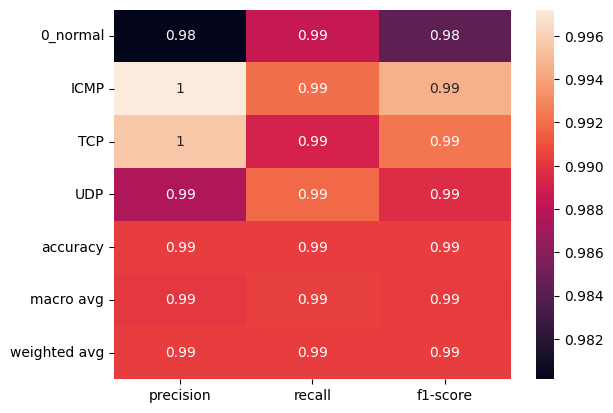

Testing time for KiNN: 20.73636507987976
MCC score: 0.9869926701145061
Confusion matrix
[[2664    1   13   17]
 [  20 2501    0    0]
 [  14    6 3365   17]
 [  20    0    2 2682]]
*************************************** End Round ***************************************


In [11]:
__res = []
__classes = np.sort(df[__TARGET].unique())
__range = np.concatenate((["*"],["**"] ,__classes), axis=0)


for drop_cls in __range:
    if drop_cls == "0_normal":
        continue
    elif drop_cls == "*":
        __MODE = "Supervise"
    elif drop_cls == "**":
        __MODE = "1_Cls"
        continue
    else:
        __MODE = "Novelty_multi"
        continue
    drop_clss = [drop_cls]
    for seed in [42]:
        __SEED = seed
        res_tmp = Running_Experiment_Novelty_Realistic(drop_clss, df.copy())

        for x in res_tmp:
            __res.append([__KERNEL,__TYPE, __SEED] + x)



res_df = pd.DataFrame(__res, columns = ["Kernel", "Type","Seed","Drop Cls",
                                          "MCC", "NDR", "AUC_N", "ACC", "TPR Macro",
                                        "FPR", "PPV Macro", "F1 Macro", "AUC", "CLS Report",
                                        "CFS Matrix", "Threshold", "Training time", "Test time"])

In [12]:
res_df
res_df.to_csv(f"./res_kinn_{__KNN}_novelty_{__TYPE}_{__KERNEL}_{__SCALER}.csv",index = False)

### Base Line

#### Evaluate function def

In [13]:
from sklearn.metrics import matthews_corrcoef

def Evaluate_Model(y_test, y_pred):
  # acc = accuracy_score(y_test, y_pred)
  mcc = matthews_corrcoef(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average = "macro")
  cnf_matrix = confusion_matrix(y_test, y_pred)

  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)

  acc = sum(TP+TN)/(sum(TP+FP+FN+TN)) *100.
  tpr_func = recall_score(y_test,y_pred,average='macro', zero_division = 0) *100.
  ppv_func = precision_score(y_test,y_pred,average='macro', zero_division = 0) *100.
  f1_func = f1_score(y_test,y_pred,average='macro', zero_division = 0) *100.
  mcc_func = matthews_corrcoef(y_test,y_pred)
  FPR = sum(FP)/sum((FP+TN)) *100.

  return acc, f1, cnf_matrix, tpr_func, ppv_func, f1_func, mcc_func, FPR

#### Baseline Supervise models mode

In [14]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [15]:
def Model_evaluating(y_true, y_pred, __Label_use_name, export_fig = None):
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_pred = np.array(y_pred)
    emberdf = pd.DataFrame({
        'y_pred': y_pred.astype(int),
        'label': y_true.astype(int)})
    # print(emberdf)
    mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, cnf_matrix = calc_index(emberdf,__Label_use_name,export_fig)

    clf_report = classification_report(emberdf.label,
                                    emberdf.y_pred,
                                    # labels=[*range(len(__Label_use_name))],
                                    target_names=__Label_use_name,
                                    output_dict=True,
                                    zero_division = 0)

    # print("Classification report:")
    # target_names = [str(label) for label in np.unique(y_true)]
    # print(classification_report(emberdf.label,
    #                                 emberdf.y_pred,
    #                                     labels=np.unique(y_true),
    #                                     target_names=__Label_use_name,
    #                                     output_dict=False,
    #                                     zero_division = 0))

  # plot cfs report
    fig = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True).get_figure()
    plt.show()

    if export_fig is not None:
        fig.savefig(os.path.join(export_fig,'cfs_report.png'))

  # print("=========================================================")

    return mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix


In [16]:
__Prameter_profile = {
    'RF': {
        'n_estimators': 5,  # Number of trees in the forest
        'max_depth': 5,    # Maximum depth of the tree. Default is None (nodes are expanded until all leaves contain less than min_samples_split samples)
        'min_samples_split': 2,  # Minimum number of samples required to split an internal node
        'min_samples_leaf': 2,   # Minimum number of samples required to be at a leaf node
        'bootstrap': True,       # Whether bootstrap samples are used when building trees
        'random_state': 42  ,     # Seed used by the random number generator
        
    
    },
    'LGBM': {
            "boosting_type": "gbdt",
            "colsample_bynode": 1,
            "colsample_bytree": 1,
            "extra_trees": True,
            "learning_rate": 0.03,
            "l1_regularization": 0.1,
            "l2_regularization": 10,
            "max_depth": 5,
            "n_estimators": 20,
            "num_leaves": 10,
            "random_state": 42,
            "verbose": -1,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
    },
    'SVC': {
        'C': 0.2,
        'kernel': "linear",
        'random_state': 42
    }

}

In [17]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import time

__SEED = 42
__TARGET = "Label"
#__SCALER = "StandardScaler"
__MODE = "Supervise"


def baseline_model(data):
    start_time_training = time.time()

    print("+" + "-" * 48 + "+")
    print("|" + " " * 15 + "CONFIG RUNNING INFO" + " " * 14 + "|")
    print("+" + "-" * 48 + "+")

    config_info = [
        ("Running Mode:", __MODE),
        ("Scaler Type:", __SCALER)
    ]

    max_name_length = max(len(name) for name, _ in config_info)

    for name, value in config_info:
        print("| " + f"{name.ljust(max_name_length)} {value}".ljust(46) + " |")

    print("+" + "-" * 48 + "+")

    drop_cls = "*"
    X_train, y_train, X_test, y_test, classes_tmp, encoder = preprocess_data(drop_cls, data)

    # Initialize an empty list to store results for each model
    results_list = []

    models = ['RandomForest', 'LGBM', 'SVM', 'KNN']
    classifiers = [RandomForestClassifier(**__Prameter_profile['RF']),
                   LGBMClassifier(**__Prameter_profile['LGBM']),
                   SVC(**__Prameter_profile['SVC']),
                   KNeighborsClassifier()]

    for model, clf in zip(models, classifiers):
        start_time = time.time()
        clf.fit(X_train, y_train)
        end_time = time.time()
        train_time = end_time - start_time

        start_time = time.time()
        y_pred = clf.predict(X_test)
        end_time = time.time()
        pred_time = end_time - start_time

        mcc, acc, tpr_func, fpr, ppv_func, f1_func, auc_func, clf_report, cnf_matrix = Model_evaluating(y_test, y_pred, classes_tmp)

        results_list.append({
            'Model': model,
            'Parameters': clf.get_params(),
            'Accuracy': acc,
            'MCC': mcc,
            'Classification Report': classification_report(y_test, y_pred),
            'Training Time (s)': train_time,
            'Testing Time (s)': pred_time,
            'PPV_macro': ppv_func,
            'F1_score_macro': f1_func,
            'TPR_macro': tpr_func,
            'FPR': fpr,
            'Confusion Matrix': cnf_matrix
        })

    df_results = pd.DataFrame(results_list)

    return df_results

Running baseline_model with scaler: StandardScaler
+------------------------------------------------+
|               CONFIG RUNNING INFO              |
+------------------------------------------------+
| Running Mode: Supervise                        |
| Scaler Type:  StandardScaler                   |
+------------------------------------------------+
X_train shape: (25410, 22)
y_train counts: (array([0, 1, 2, 3]), array([6289, 5588, 7540, 5993]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1, 2, 3]), array([2695, 2521, 3402, 2704]))
TPR-macro: 98.5934
FPR      : 0.4946
PPV-macro: 98.4988
F1-macro : 98.5296
MCC-func  : 0.9802
AUC-func  : -1.0000
CFS MATRIX:
 [[2684    2    1    8]
 [  24 2497    0    0]
 [  66    2 3316   18]
 [  44    0    3 2657]]


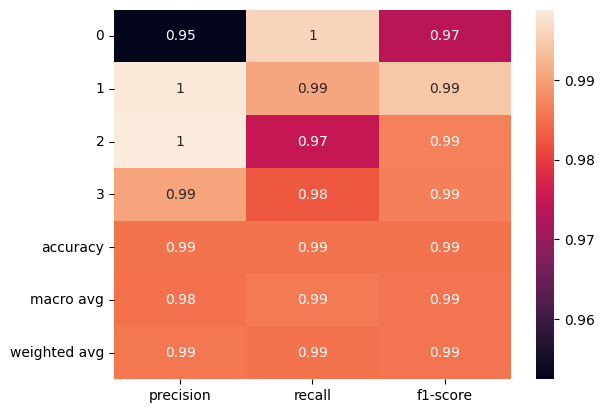

TPR-macro: 98.6206
FPR      : 0.4711
PPV-macro: 98.5441
F1-macro : 98.5790
MCC-func  : 0.9811
AUC-func  : -1.0000
CFS MATRIX:
 [[2646    2    3   44]
 [  18 2494    9    0]
 [  42   12 3339    9]
 [  21    0    0 2683]]


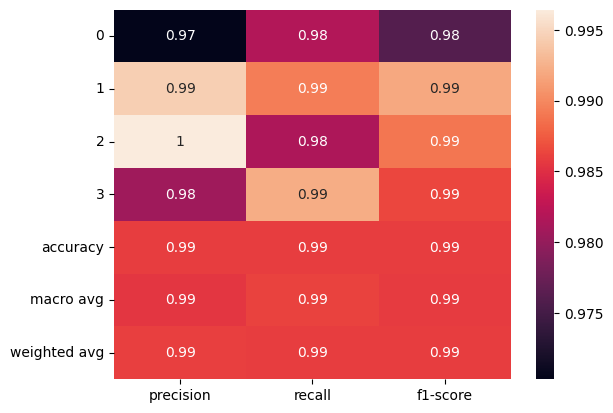

TPR-macro: 96.4785
FPR      : 1.1747
PPV-macro: 96.6037
F1-macro : 96.4164
MCC-func  : 0.9537
AUC-func  : -1.0000
CFS MATRIX:
 [[2688    2    1    4]
 [  61 2460    0    0]
 [  57   45 3292    8]
 [ 221    0    0 2483]]


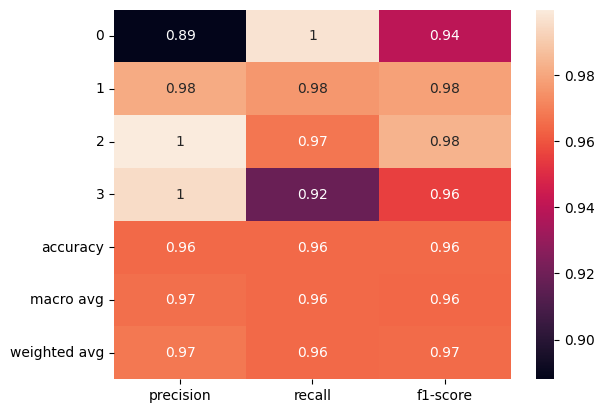

TPR-macro: 99.0170
FPR      : 0.3356
PPV-macro: 98.9643
F1-macro : 98.9892
MCC-func  : 0.9865
AUC-func  : -1.0000
CFS MATRIX:
 [[2671    4    3   17]
 [   2 2512    7    0]
 [  19    0 3361   22]
 [  37    3    0 2664]]


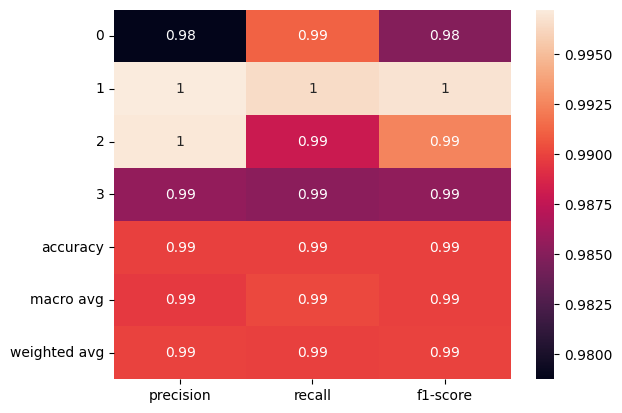

Running baseline_model with scaler: MinMaxScaler
+------------------------------------------------+
|               CONFIG RUNNING INFO              |
+------------------------------------------------+
| Running Mode: Supervise                        |
| Scaler Type:  MinMaxScaler                     |
+------------------------------------------------+
X_train shape: (25410, 22)
y_train counts: (array([0, 1, 2, 3]), array([6289, 5588, 7540, 5993]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1, 2, 3]), array([2695, 2521, 3402, 2704]))
TPR-macro: 98.7232
FPR      : 0.4475
PPV-macro: 98.6133
F1-macro : 98.6641
MCC-func  : 0.9821
AUC-func  : -1.0000
CFS MATRIX:
 [[2647    1    1   46]
 [   7 2514    0    0]
 [  48    6 3331   17]
 [  21    0    5 2678]]


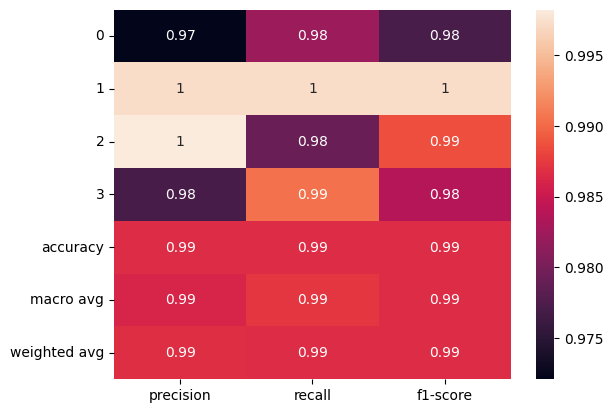

TPR-macro: 98.2691
FPR      : 0.5947
PPV-macro: 98.1700
F1-macro : 98.2072
MCC-func  : 0.9762
AUC-func  : -1.0000
CFS MATRIX:
 [[2609    2    1   83]
 [  20 2494    7    0]
 [  45   10 3319   28]
 [   6    0    0 2698]]


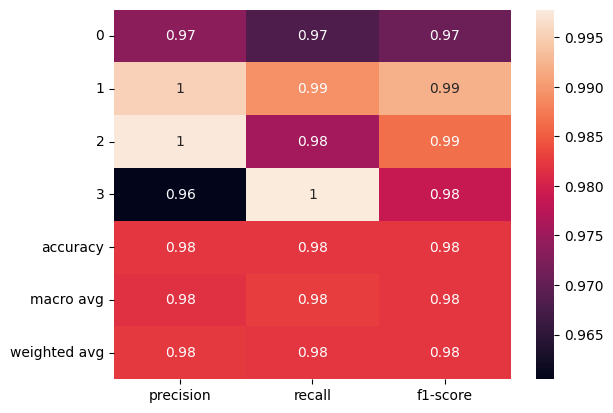

TPR-macro: 94.4632
FPR      : 1.9255
PPV-macro: 94.3912
F1-macro : 94.2113
MCC-func  : 0.9243
AUC-func  : -1.0000
CFS MATRIX:
 [[2686    2    3    4]
 [ 119 2402    0    0]
 [  90  211 3091   10]
 [ 215    0    0 2489]]


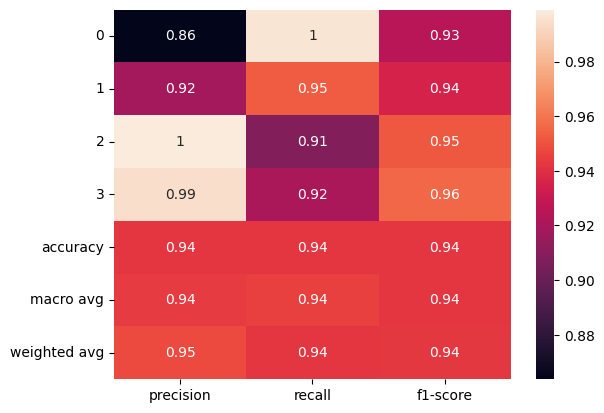

TPR-macro: 99.1408
FPR      : 0.2856
PPV-macro: 99.1178
F1-macro : 99.1268
MCC-func  : 0.9885
AUC-func  : -1.0000
CFS MATRIX:
 [[2675    2    4   14]
 [   7 2513    1    0]
 [  14    0 3379    9]
 [  46    0    0 2658]]


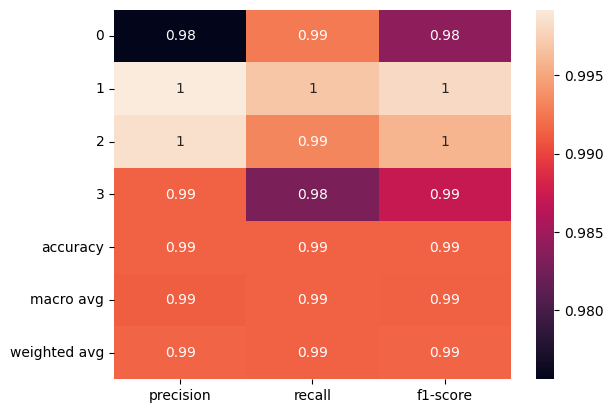

Running baseline_model with scaler: QuantileTransformer
+------------------------------------------------+
|               CONFIG RUNNING INFO              |
+------------------------------------------------+
| Running Mode: Supervise                        |
| Scaler Type:  QuantileTransformer              |
+------------------------------------------------+
X_train shape: (25410, 22)
y_train counts: (array([0, 1, 2, 3]), array([6289, 5588, 7540, 5993]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1, 2, 3]), array([2695, 2521, 3402, 2704]))
TPR-macro: 98.7144
FPR      : 0.4446
PPV-macro: 98.6559
F1-macro : 98.6751
MCC-func  : 0.9822
AUC-func  : -1.0000
CFS MATRIX:
 [[2682    3    2    8]
 [  17 2494   10    0]
 [  55    2 3334   11]
 [  38    2    3 2661]]


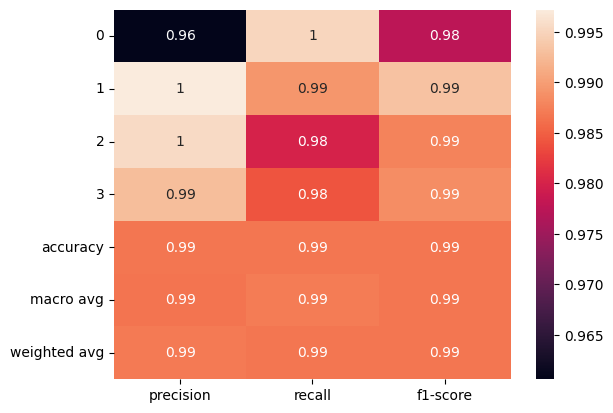

TPR-macro: 98.4352
FPR      : 0.5358
PPV-macro: 98.3562
F1-macro : 98.3853
MCC-func  : 0.9785
AUC-func  : -1.0000
CFS MATRIX:
 [[2616    3    3   73]
 [  18 2494    9    0]
 [  36    9 3329   28]
 [   3    0    0 2701]]


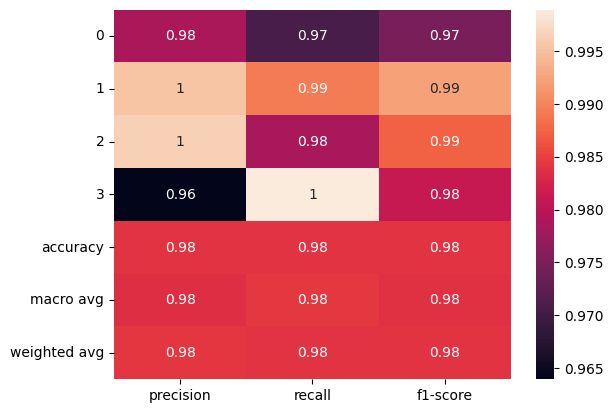

TPR-macro: 99.2877
FPR      : 0.2296
PPV-macro: 99.3140
F1-macro : 99.3001
MCC-func  : 0.9908
AUC-func  : -1.0000
CFS MATRIX:
 [[2671    3   10   11]
 [   5 2507    9    0]
 [   9    0 3392    1]
 [  30    0    0 2674]]


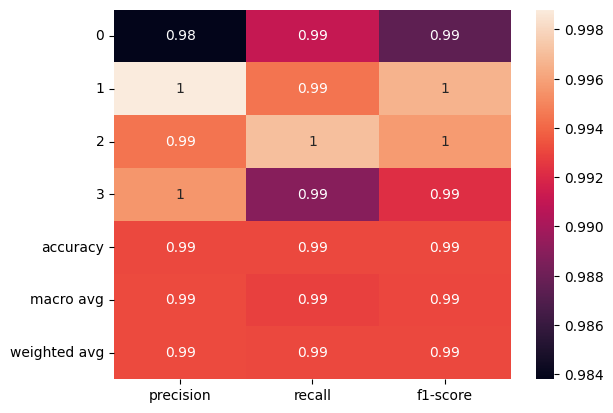

TPR-macro: 99.3249
FPR      : 0.2208
PPV-macro: 99.3312
F1-macro : 99.3275
MCC-func  : 0.9911
AUC-func  : -1.0000
CFS MATRIX:
 [[2672    2   13    8]
 [  14 2507    0    0]
 [   7    0 3387    8]
 [  23    0    0 2681]]


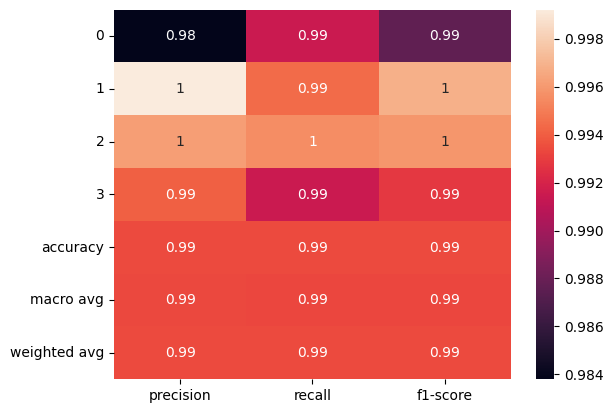

Running baseline_model with scaler: Normalizer
+------------------------------------------------+
|               CONFIG RUNNING INFO              |
+------------------------------------------------+
| Running Mode: Supervise                        |
| Scaler Type:  Normalizer                       |
+------------------------------------------------+
X_train shape: (25410, 22)
y_train counts: (array([0, 1, 2, 3]), array([6289, 5588, 7540, 5993]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1, 2, 3]), array([2695, 2521, 3402, 2704]))
TPR-macro: 81.5770
FPR      : 6.4830
PPV-macro: 82.0770
F1-macro : 80.8287
MCC-func  : 0.7481
AUC-func  : -1.0000
CFS MATRIX:
 [[2315  165  215    0]
 [   1 2520    0    0]
 [ 508  161 2375  358]
 [ 785    5    4 1910]]


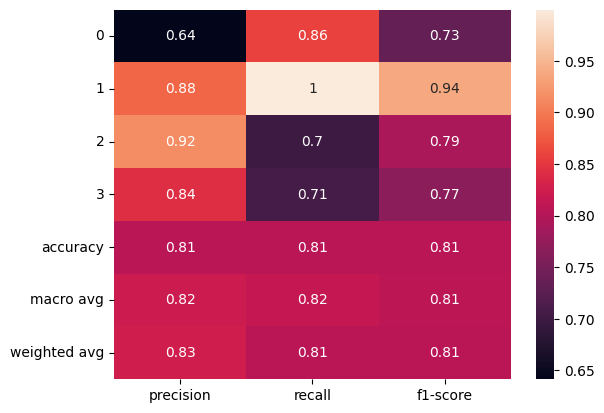

TPR-macro: 98.3577
FPR      : 0.5741
PPV-macro: 98.2423
F1-macro : 98.2887
MCC-func  : 0.9770
AUC-func  : -1.0000
CFS MATRIX:
 [[2659    2    2   32]
 [  31 2485    5    0]
 [  65    7 3304   26]
 [  22    0    3 2679]]


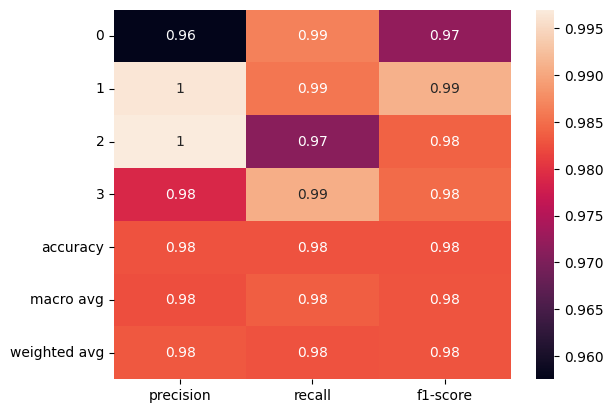

TPR-macro: 25.0000
FPR      : 23.3174
PPV-macro: 7.5119
F1-macro : 11.5526
MCC-func  : 0.0000
AUC-func  : -1.0000
CFS MATRIX:
 [[   0    0 2695    0]
 [   0    0 2521    0]
 [   0    0 3402    0]
 [   0    0 2704    0]]


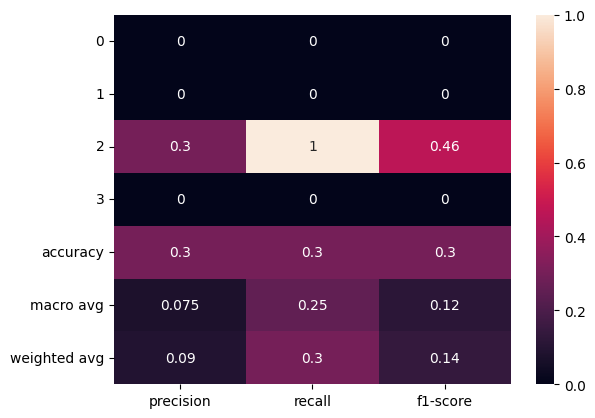

/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

TPR-macro: 95.0122
FPR      : 1.7223
PPV-macro: 94.8145
F1-macro : 94.8988
MCC-func  : 0.9310
AUC-func  : -1.0000
CFS MATRIX:
 [[2556   30   40   69]
 [  29 2462   30    0]
 [  91   36 3157  118]
 [  94    0   48 2562]]


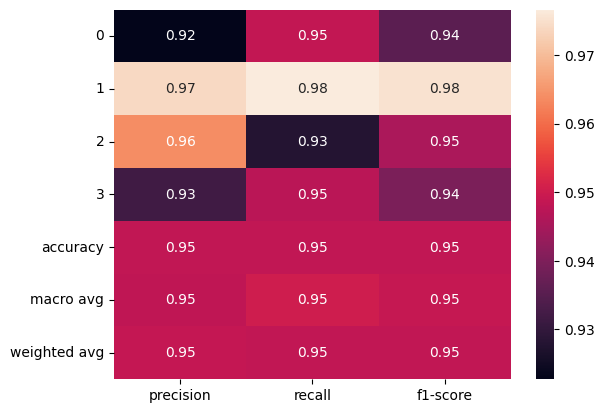

In [18]:
# Danh sách tên của các scaler cần thử
scaler_names = ["StandardScaler", "MinMaxScaler", "QuantileTransformer", "Normalizer"]

# Kết quả sẽ được lưu vào một danh sách
all_results = []

# Lặp qua từng tên scaler và chạy baseline_model
for scaler_name in scaler_names:
    print(f"Running baseline_model with scaler: {scaler_name}")
    __SCALER = scaler_name  # Thiết lập giá trị của __SCALER
    results = baseline_model(df.copy())  # Chạy baseline_model với scaler hiện tại
    all_results.append(results)

# Kết hợp tất cả các kết quả vào một DataFrame
final_results = pd.concat(all_results, keys=scaler_names, names=["Scaler"])

In [19]:
final_results.to_csv("supervised.csv")

#### Baseline One Class models mode

In [20]:
!pip install pyod
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.inne import INNE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [21]:
__MODE = "1_Cls"
__SEED = 42
__SCALER = "QuantileTransformer"

def baseline_model_1Cls(data):
    drop_cls = "*"
    X_train, y_train, X_test, y_test, classes_tmp, encoder = preprocess_data(drop_cls, data)


    iforest_clf = IForest()
    iforest_clf.fit(X_train, y_train)

    iforest_pred = iforest_clf.predict(X_test)
    iforest_acc, iforest_f1, iforest_cnf_matrix, iforest_tpr_func, iforest_ppv_func, iforest_f1_func, iforest_mcc_func, iforest_FPR = Evaluate_Model(y_test, iforest_pred)



    lof_clf = LOF()
    lof_clf.fit(X_train, y_train)
    lof_pred = lof_clf.predict(X_test)
    lof_acc, lof_f1, lof_cnf_matrix, lof_tpr_func, lof_ppv_func, lof_f1_func, lof_mcc_func, lof_FPR = Evaluate_Model(y_test, lof_pred)


    ocsvm_clf = OCSVM()
    ocsvm_clf.fit(X_train, y_train)
    ocsvm_pred = ocsvm_clf.predict(X_test)
    ocsvm_acc, ocsvm_f1, ocsvm_cnf_matrix, ocsvm_tpr_func, ocsvm_ppv_func, ocsvm_f1_func, ocsvm_mcc_func, ocsvm_FPR = Evaluate_Model(y_test, ocsvm_pred)


    abod_clf = ABOD()
    abod_clf.fit(X_train, y_train)
    abod_pred = abod_clf.predict(X_test)
    abod_acc, abod_f1, abod_cnf_matrix, abod_tpr_func, abod_ppv_func, abod_f1_func, abod_mcc_func, abod_FPR = Evaluate_Model(y_test, abod_pred)

    inne_clf = INNE()
    inne_clf.fit(X_train, y_train)
    inne_pred = inne_clf.predict(X_test)
    inne_acc, inne_f1, inne_cnf_matrix, inne_tpr_func, inne_ppv_func, inne_f1_func, inne_mcc_func, inne_FPR = Evaluate_Model(y_test, inne_pred)

    models = ['IForest', 'LOF', 'OCSVM', 'ABOD', 'INNE']
    parameters = [iforest_clf.get_params(), lof_clf.get_params(), ocsvm_clf.get_params(), abod_clf.get_params(), inne_clf.get_params()]
    accuracies = [iforest_acc, lof_acc, ocsvm_acc, abod_acc, inne_acc]
    mccs = [iforest_mcc_func, lof_mcc_func, ocsvm_mcc_func, abod_mcc_func, inne_mcc_func]
    f1_scores = [iforest_f1, lof_f1, ocsvm_f1, abod_f1, inne_f1]
    tprs = [iforest_tpr_func, lof_tpr_func, ocsvm_tpr_func, abod_tpr_func, inne_tpr_func]
    fprs = [iforest_FPR, lof_FPR, ocsvm_FPR, abod_FPR, inne_FPR]
    ppvs = [iforest_ppv_func, lof_ppv_func, ocsvm_ppv_func, abod_ppv_func, inne_ppv_func]
    matrix = [iforest_cnf_matrix, lof_cnf_matrix, ocsvm_cnf_matrix, abod_cnf_matrix, inne_cnf_matrix]

    results = {
        'Model': models,
        'Parameters': parameters,
        'Accuracy': accuracies,
        'MCC': mccs,
        'F1 Score': f1_scores,
        'TPR': tprs,
        'FPR': fprs,
        'PPV': ppvs,
        'Confusion-matrix': matrix
    }

    df_results = pd.DataFrame(results)

    return df_results

results = baseline_model_1Cls(df.copy())
results

X_train shape: (6289, 22)
y_train counts: (array([0]), array([6289]))
X_test shape: (11322, 22)
y_test counts: (array([0, 1]), array([2695, 8627]))


/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/jupyter-iec_portscan/.local/lib/python3.10/site-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


,Model,Parameters,Accuracy,MCC,F1 Score,TPR,FPR,PPV,Confusion-matrix
0,IForest,"{'behaviour': 'old', 'bootstrap': False, 'cont...",81.125243,0.599220,0.778688,84.119016,18.874757,76.309727,"[[2421, 274], [1863, 6764]]"
1,LOF,"{'algorithm': 'auto', 'contamination': 0.1, 'l...",90.637697,0.763949,0.878808,90.488618,9.362303,86.035927,"[[2431, 264], [796, 7831]]"
2,OCSVM,"{'cache_size': 200, 'coef0': 0.0, 'contaminati...",97.465112,0.929560,0.963977,95.032524,2.534888,97.969863,"[[2436, 259], [28, 8599]]"
3,ABOD,"{'contamination': 0.1, 'method': 'fast', 'n_ne...",96.581876,0.904484,0.951806,94.185049,3.418124,96.287759,"[[2415, 280], [107, 8520]]"
4,INNE,"{'contamination': 0.1, 'max_samples': 'auto', ...",97.138315,0.920187,0.959548,94.830838,2.861685,97.218831,"[[2437, 258], [66, 8561]]"


In [22]:
results.to_csv(f"One_class_cidds_{__SCALER}.csv")